In [354]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [355]:
# Read the dataset
db = pd.read_csv("diabetes.csv")

In [356]:
# Dealing with outliers
# Define a function to find the outlier thresholds
# According to data structure, business area different quartiles like 0.1, 0.9 can be selected.
# For linear models, we need to analyse outliers. 

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# We have defined a function which has_outliers
# It will give the names of the columns having outliers
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable,"coulmn has outliers")  
        
for col in db.columns:
    has_outliers(db, col)

BloodPressure coulmn has outliers
Insulin coulmn has outliers
DiabetesPedigreeFunction coulmn has outliers


In [357]:
# Replacing the columns values having outliers with lower and upper limits 
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
        replace_with_thresholds(db, db.columns)
        for col in db.columns:
            has_outliers(db, col)

In [358]:
# For Glucose Tolerance Test(GLT)
# Normal Results for Diabetes -> Two-hour glucose level less than 140 mg/dL
# Impaired Results for Diabetes -> Two-hour glucose level 140 to 200 mg/dL
# Abnormal (Diagnostic) Results for Diabetes -> Two-hour glucose level greater than 200 mg/dL

db['New_GLT'] = pd.cut(x=db['Glucose'], bins=[0,139,200,250],labels = ["Normal","Impaired","Abnormal"])

In [359]:
# BMI
# Below 18.5 -> Underweight
# 18.5 – 24.9 -> Normal or Healthy Weight
# 25.0 – 29.9 -> Overweight
# 30.0 and Above -> Obese

db['New_BMI'] = pd.cut(x=db['BMI'], bins=[0,18.4,24.9,29.9,70],labels = ["Underweight","Healty or Normal","Overweight","Obese"])

In [360]:
# Blood Pressure(BP)
# Normal: Systolic below 120 and diastolic below 80
# Elevated: Systolic 120–129 and diastolic under 80
# Hypertension stage 1(HS1): Systolic 130–139 and diastolic 80–89
# Hypertension stage 2(HS2): Systolic 140-plus and diastolic 90 or more
# Hypertensive crisis(HC): Systolic higher than 180 and diastolic above 120.

db['New_BP'] = pd.cut(x=db['BloodPressure'], bins=[0,79,89,120,150],labels = ["Normal","HS1","HS2","HC"])

In [361]:
# Triceps Skinfolds
# For adults, the standard normal values for triceps skinfolds is 18.0 mm for women

db['New_SThick'] = db['SkinThickness'].apply(lambda x: 1 if x <= 18.0 else 0)

In [362]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns


In [363]:
categorical_columns = [col for col in db.columns
                           if len(db[col].unique()) <= 10
                      and col != "Outcome"]

db, new_cols_ohe = one_hot_encoder(db,categorical_columns)

In [364]:
from sklearn.preprocessing import RobustScaler
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

like_num = [col for col in db.columns if db[col].dtypes != 'O' and len(db[col].value_counts()) < 10]
cols_need_scale = [col for col in db.columns if col not in new_cols_ohe
                   and col not in "Outcome"
                   and col not in like_num]

for col in cols_need_scale:
    db[col] = robust_scaler(db[col])

In [365]:
#prepare the data
X = db.drop(['Outcome'],axis =1)
#prepare the target
Y = db['Outcome']

In [366]:
#split the dataset into train and test 
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.20, random_state = 42)
# split the training data into training and validation set
X_train1,X_val,Y_train1,Y_val = train_test_split(X_train,Y_train,test_size = 0.125 ,random_state = 42)

In [367]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train1)
scaler.fit(X_val)
scaler.fit(X_test)
scaled_data = scaler.transform(X_train1)
scaled_data1 = scaler.transform(X_val)
scaled_data2 = scaler.transform(X_test)  

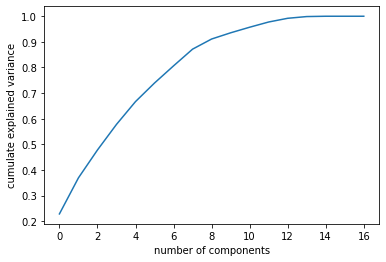

In [368]:
from sklearn.decomposition import PCA
pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulate explained variance')
plt.show()

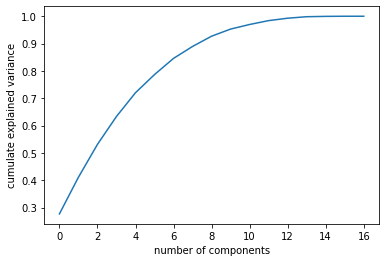

In [369]:
from sklearn.decomposition import PCA
pca = PCA().fit(scaled_data1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulate explained variance')
plt.show()

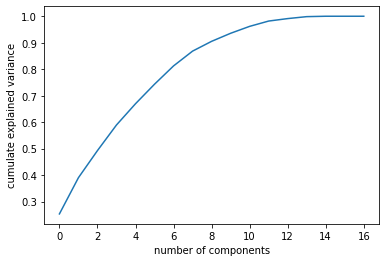

In [370]:
from sklearn.decomposition import PCA
pca = PCA().fit(scaled_data2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulate explained variance')
plt.show()

# Principal Component Analysis

In [371]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(scaled_data)
pca.fit(scaled_data1)
pca.fit(scaled_data2)
x_pca = pca.transform(scaled_data)
x_pca1 = pca.transform(scaled_data1)
x_pca2 = pca.transform(scaled_data2)
print(pca.explained_variance_ratio_)

[0.2533396  0.13688773]


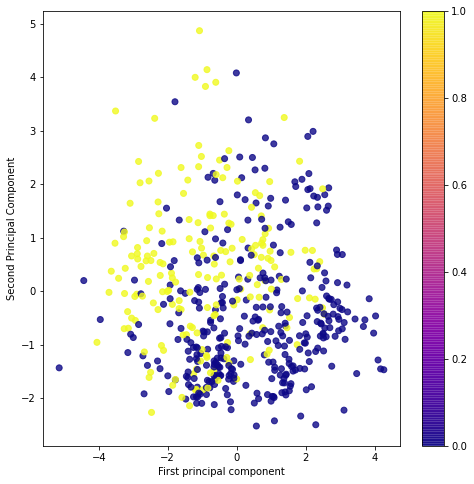

In [372]:
plt.figure(figsize=(8,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c=Y_train1,cmap='plasma',alpha = 0.8)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.colorbar()

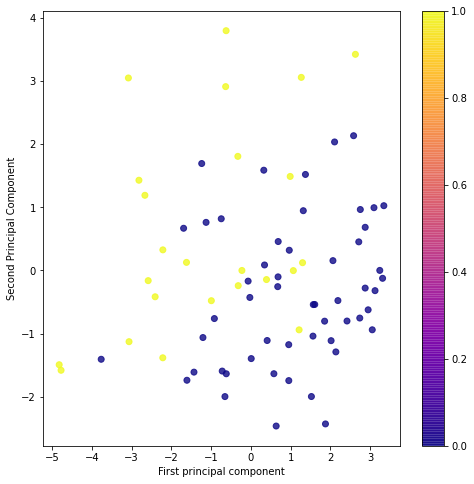

In [373]:
plt.figure(figsize=(8,8))
plt.scatter(x_pca1[:,0],x_pca1[:,1],c=Y_val,cmap='plasma',alpha = 0.8)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.colorbar()

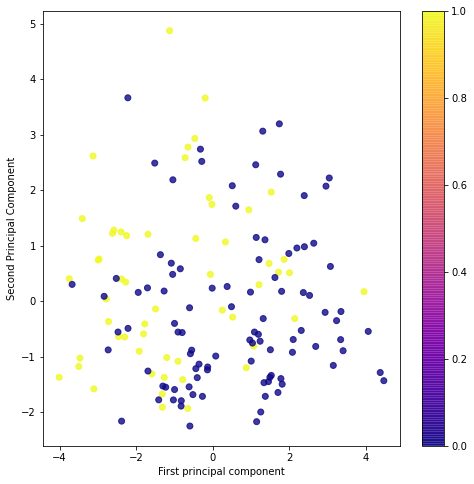

In [374]:
plt.figure(figsize=(8,8))
plt.scatter(x_pca2[:,0],x_pca2[:,1],c=Y_test,cmap='plasma',alpha = 0.8)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.colorbar()

# SVM on PCA

In [375]:
#import the important libraries
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize Features
scaler = StandardScaler()
scaler.fit(x_pca)
scaler.fit(x_pca1)
scaler.fit(x_pca2)
x_pca_0 = scaler.transform(x_pca)
x_pca_1 = scaler.transform(x_pca1)
x_pca_2 = scaler.transform(x_pca2)


In [376]:
# SVM Kernels( Accuracy on training dataset)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(x_pca_0, Y_train1)
    y_pred = model.predict(x_pca_0)
    print(k)
    print(accuracy_score(Y_train1, y_pred)) 

linear
0.7299813780260708
poly
0.7132216014897579
rbf
0.7541899441340782
sigmoid
0.6256983240223464


In [377]:
# SVM Kernels(Accuracy on validation set)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(x_pca_1, Y_val)
    y_pred1 = model.predict(x_pca_1)
    print(k)
    print(accuracy_score(Y_val, y_pred1))

linear
0.8051948051948052
poly
0.8311688311688312
rbf
0.8441558441558441
sigmoid
0.7402597402597403


In [378]:
# SVM Kernels( Accuracy on test dataset)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(x_pca_2, Y_test)
    y_pred2 = model.predict(x_pca_2)
    print(k)
    print(accuracy_score(Y_test, y_pred2))

linear
0.7142857142857143
poly
0.7142857142857143
rbf
0.7337662337662337
sigmoid
0.6233766233766234


# Linear Discriminant Analysis

In [379]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
lda.fit(scaled_data,Y_train1)
lda.fit(scaled_data1,Y_val)
lda.fit(scaled_data2,Y_test)
X_lda = lda.transform(scaled_data)
X_lda1 = lda.transform(scaled_data1)
X_lda2 = lda.transform(scaled_data2)

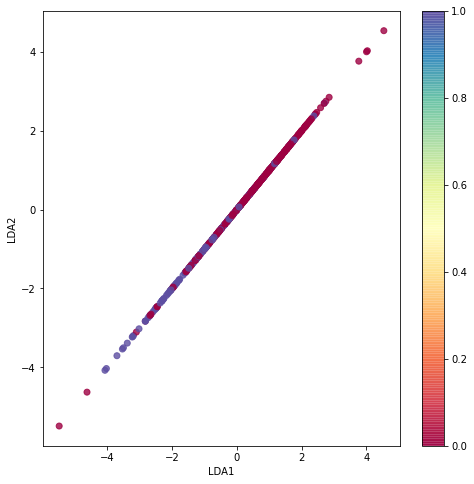

In [380]:
plt.figure(figsize=(8,8))
plt.scatter(X_lda[:,0],X_lda[:,-1],c=Y_train1,cmap='Spectral',alpha = 0.8)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.colorbar()

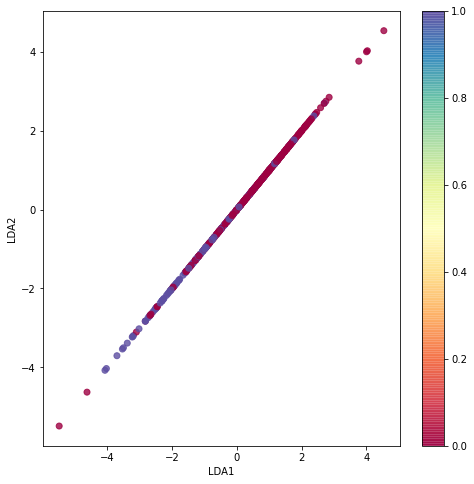

In [381]:
plt.figure(figsize=(8,8))
plt.scatter(X_lda[:,0],X_lda[:,-1],c=Y_train1,cmap='Spectral',alpha = 0.8)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.colorbar()

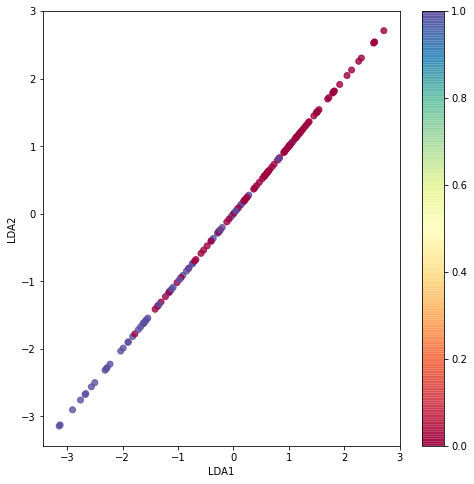

In [382]:
plt.figure(figsize=(8,8))
plt.scatter(X_lda2[:,0],X_lda2[:,-1],c=Y_test,cmap='Spectral',alpha = 0.8)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.colorbar()

# SVM after LDA

In [383]:
# normal features
scaler = StandardScaler()
scaler.fit(X_lda)
scaler.fit(X_lda1)
scaler.fit(X_lda2)
X_lda_0 = scaler.transform(X_lda)
X_lda_1 = scaler.transform(X_lda1)
X_lda_2 = scaler.transform(X_lda2)

In [384]:
# SVM Kernels( Accuracy on training dataset)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(X_lda_0, Y_train1)
    y_pred = model.predict(X_lda_0)
    print(k)
    print(accuracy_score(Y_train1, y_pred)) 

linear
0.7355679702048417
poly
0.6703910614525139
rbf
0.7411545623836127
sigmoid
0.6573556797020484


In [385]:
# SVM Kernels( Accuracy on validation dataset)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(X_lda_1, Y_val)
    y_pred = model.predict(X_lda_1)
    print(k)
    print(accuracy_score(Y_val, y_pred))

linear
0.8051948051948052
poly
0.7532467532467533
rbf
0.8181818181818182
sigmoid
0.6753246753246753


In [386]:
# SVM Kernels( Accuracy on test dataset)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(X_lda_2, Y_test)
    y_pred = model.predict(X_lda_2)
    print(k)
    print(accuracy_score(Y_test, y_pred))

linear
0.8246753246753247
poly
0.7987012987012987
rbf
0.8376623376623377
sigmoid
0.7272727272727273
